In [1]:
import sys
sys.path.append('ML4QS-master')
%matplotlib inline

import copy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
from util import util
from util.VisualizeDataset import VisualizeDataset
data1 = pd.read_csv('./datasets/bike.csv',sep=";")
data1.head()
DataViz = VisualizeDataset()

# Chapter 2: Basics of Sensory Data

In [36]:
data1 = data1.iloc[:,:16]
data1 = data1.dropna()
data1.shape
#data1.info()
#type object instead of float64..
#data1 = data1.astype('float64', raise_on_error = True) #doesnot work
#data1 = pd.to_numeric(data1, errors= 'coerce') #doesnt work
data1 = data1.convert_objects(convert_numeric=True) #Type 'Number' in Excel becomes NaN,  type 'General' gets float
#might wanna focus on the 2 sources that are complete: rotation/gravity
rotation_data = data1.iloc[:,4:7] #has NaN
rotation_data.head()
gravity_data = data1.iloc[:,7:10] #no NaN
user_acc_data = data1.iloc[:,10:13] #has NaN
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34748 entries, 0 to 34747
Data columns (total 1 columns):
timestamp(unix),attitude_roll(radians),attitude_pitch(radians),attitude_yaw(radians),rotation_rate_x(radians/s),rotation_rate_y(radians/s),rotation_rate_z(radians/s),gravity_x(G),gravity_y(G),gravity_z(G),user_acc_x(G),user_acc_y(G),user_acc_z(G),magnetic_field_x(microteslas),magnetic_field_y(microteslas),magnetic_field_z(microteslas),latitude(degree),longitude(degree),altitude(meter),speed(m/s),course(degree),timestamp(unix),User Mark    34748 non-null object
dtypes: object(1)
memory usage: 542.9+ KB


/Users/davidstap/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [38]:
rotation_data.describe()
#plt.hist(rotation_data['rotation_rate_x(radians/s)'].dropna())
#plt.hist(rotation_data['rotation_rate_y(radians/s)'].dropna())
#plt.hist(rotation_data['rotation_rate_z(radians/s)'].dropna())
#plt.show()
DataViz.plot_dataset_boxplot(rotation_data, ['rotation_rate_x(radians/s)','rotation_rate_y(radians/s)','rotation_rate_z(radians/s)'])

In [ ]:
gravity_data.describe()
#plt.hist(gravity_data['gravity_x(G)'])
#plt.hist(gravity_data['gravity_y(G)'])
#plt.hist(gravity_data['gravity_z(G)'])
#plt.show()
DataViz.plot_dataset_boxplot(gravity_data, ['gravity_x(radians/s)','gravity_rate_y(radians/s)','gravity_rate_z(radians/s)'])

In [ ]:
user_acc_data.describe()
#plt.hist(user_acc_data['user_acc_x(G)'].dropna())
#plt.hist(user_acc_data['user_acc_y(G)'].dropna())
#plt.hist(user_acc_data['user_acc_z(G)'].dropna())
#plt.show()
DataViz.plot_dataset_boxplot(user_acc_data, ['user_acc_x(radians/s)','user_acc_y(radians/s)','user_acc_z(radians/s)'])

In [ ]:
label_data = pd.DataFrame()
label_data['Sensor_type'] = ['interval_label']
label_data['Device_type'] = ['smartphone']
label_data['Label'] = ['Cycling']
label_data['Label_start'] = [data1['timestamp(unix)'].min()]
label_data['Label_end'] = [data1['timestamp(unix)'].max()]
label_data.head(5)

In [ ]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 2                                               #
#                                                            #
##############################################################

import pandas as pd
import numpy as np
import re
import copy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as md


class CreateDataset():

    base_dir = ''
    granulairity = 0
    data_table = None

    def __init__(self, base_dir, granularity):
        self.base_dir = base_dir
        self.granularity = granularity

    # Create an initial data table with entries from start till end time, with steps
    # of size granularity. Granularity is specified in milliseconds
    def create_timestamps(self, start_time, end_time):
        return pd.date_range(start_time, end_time, freq=str(self.granularity)+'ms')

    def create_dataset(self, start_time, end_time, cols, prefix):
        c = copy.deepcopy(cols)
        if not prefix == '':
            for i in range(0, len(c)):
                c[i] = str(prefix) + str(c[i])
        timestamps = self.create_timestamps(start_time, end_time)
        self.data_table = pd.DataFrame(index=timestamps, columns=c)

    # Add numerical data, we assume timestamps in the form of nanoseconds from the epoch
    def add_numerical_dataset(self, file, timestamp_col, value_cols, aggregation='avg', prefix=''):
        dataset = pd.read_csv(self.base_dir + file, skipinitialspace=True)

        # Convert timestamps to dates
        dataset[timestamp_col] = pd.to_datetime(dataset[timestamp_col])

        # Create a table based on the times found in the dataset
        if self.data_table is None:
            self.create_dataset(min(dataset[timestamp_col]), max(dataset[timestamp_col]), value_cols, prefix)
        else:
            for col in value_cols:
                self.data_table[str(prefix) + str(col)] = np.nan

        # Over all rows in the new table
        for i in range(0, len(self.data_table.index)):
            # Select the relevant measurements.
            relevant_rows = dataset[
                (dataset[timestamp_col] >= self.data_table.index[i]) &
                (dataset[timestamp_col] < (self.data_table.index[i] +
                                           timedelta(milliseconds=self.granularity)))
            ]
            for col in value_cols:
                # Take the average value
                if len(relevant_rows) > 0:
                    if aggregation == 'avg':
                        self.data_table.loc[self.data_table.index[i], str(prefix)+str(col)] = np.average(relevant_rows[col])
                    else:
                        raise ValueError("Unknown aggregation '" + aggregation + "'")
                else:
                    self.data_table.loc[self.data_table.index[i], str(prefix)+str(col)] = np.nan

    # Remove undesired value from the names.
    def clean_name(self, name):
        return re.sub('[^0-9a-zA-Z]+', '', name)

    # Add data in which we have rows that indicate the occurrence of a certain event with a given start and end time.
    # 'aggregation' can be 'sum' or 'binary'.
    def add_event_dataset(self, file, start_timestamp_col, end_timestamp_col, value_col, aggregation='sum'):
        dataset = pd.read_csv(self.base_dir + file)

        # Convert timestamps to datetime.
        dataset[start_timestamp_col] = pd.to_datetime(dataset[start_timestamp_col])
        dataset[end_timestamp_col] = pd.to_datetime(dataset[end_timestamp_col])

        # Clean the event values in the dataset
        dataset[value_col] = dataset[value_col].apply(self.clean_name)
        event_values = dataset[value_col].unique()

        # Add columns for all possible values (or create a new dataset if empty), set the default to 0 occurrences
        if self.data_table is None:
            self.create_dataset(min(dataset[start_timestamp_col]), max(dataset[end_timestamp_col]), event_values, value_col)
        for col in event_values:
            self.data_table[(str(value_col) + str(col))] = 0

        # Now we need to start counting by passing along the rows....
        for i in range(0, len(dataset.index)):
            # identify the time points of the row in our dataset and the value
            start = dataset[start_timestamp_col][i]
            end = dataset[end_timestamp_col][i]
            value = dataset[value_col][i]
            border = (start - timedelta(milliseconds=self.granularity))

            # get the right rows from our data table
            relevant_rows = self.data_table[(start <= (self.data_table.index +timedelta(milliseconds=self.granularity))) & (end > self.data_table.index)]

            # and add 1 to the rows if we take the sum
            if aggregation == 'sum':
                self.data_table.loc[relevant_rows.index, str(value_col) + str(value)] += 1
            # or set to 1 if we just want to know it happened
            elif aggregation == 'binary':
                self.data_table.loc[relevant_rows.index, str(value_col) + str(value)] = 1
            else:
                raise ValueError("Unknown aggregation '" + aggregation + "'")

    # This function returns the column names that have one of the strings expressed by 'ids' in the column name.
    def get_relevant_columns(self, ids):
        relevant_dataset_cols = []
        cols = list(self.data_table.columns)

        for id in ids:
            relevant_dataset_cols.extend([col for col in cols if id in col])

        return relevant_dataset_cols



# Chapter 3: Handling Noise and Missing Values in Sensory Data

## Practical Assignment Q3.6.2.3
Use a model-based approach to impute the heart rate

In [2]:
# Load data
data = pd.read_csv('./ML4QS-master/intermediate_datafiles/chapter2_result.csv', index_col=0)
data.index = data.index.to_datetime()

# Settings for matplotlib to ensure readable plots
plt.rcParams["figure.figsize"] = [20,15]
matplotlib.rc('font', **{'family' : 'normal', 'size'   : 22})

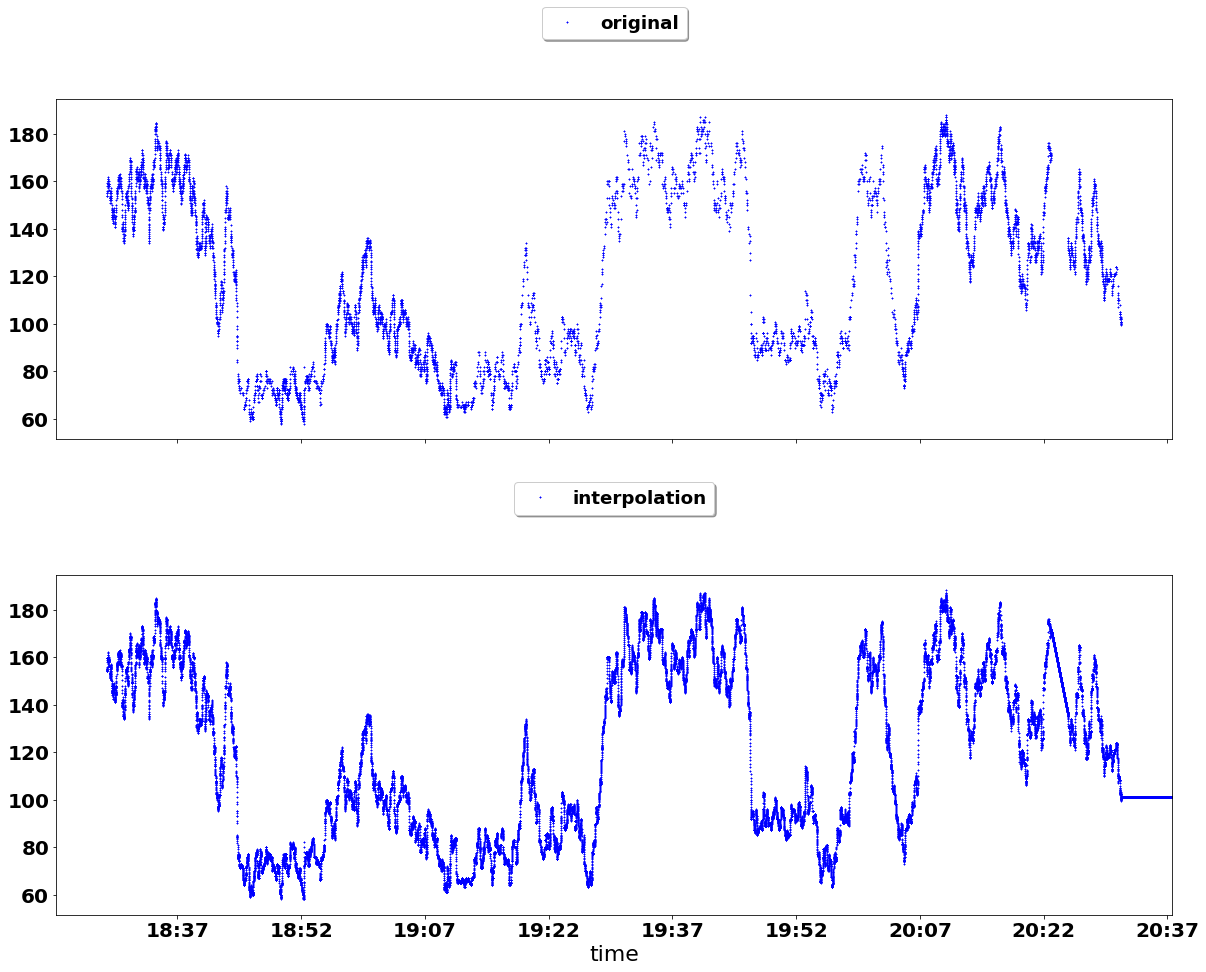

In [23]:
from Chapter3.ImputationMissingValues import ImputationMissingValues
from util.VisualizeDataset import VisualizeDataset

# Choose attribute
col = 'hr_watch_rate'

# Create imputation and visualization instance
MisVal = ImputationMissingValues()
DataViz = VisualizeDataset()

# Use interpolation function. Result: heart rate data imputed
data_imputed_interpolation = MisVal.impute_interpolate(copy.deepcopy(data),col)

# Visualize result
DataViz.plot_imputed_values(data, ['original', 'interpolation'], 'hr_watch_rate', data_imputed_interpolation['hr_watch_rate'])

## Practical Assignment Q3.6.2.2
To generate Figs. 3.8 and 3.9 we have used the parameter settings described in Sect.3.5.1. Vary the constant c (smaller and larger values) of the Chauvenet’s criterion and study the dependency of the number of detected outliers on c. Repeat this for the other three methods presented for outlier detection. Use the source code from book’s website, that generated the figures, as a starting point for the analysis.

### Distribution-based: Chauvenet's criterion

In [6]:
from Chapter3.OutlierDetection import DistributionBasedOutlierDetection

col = 'acc_phone_x'
OutlierDistr = DistributionBasedOutlierDetection()

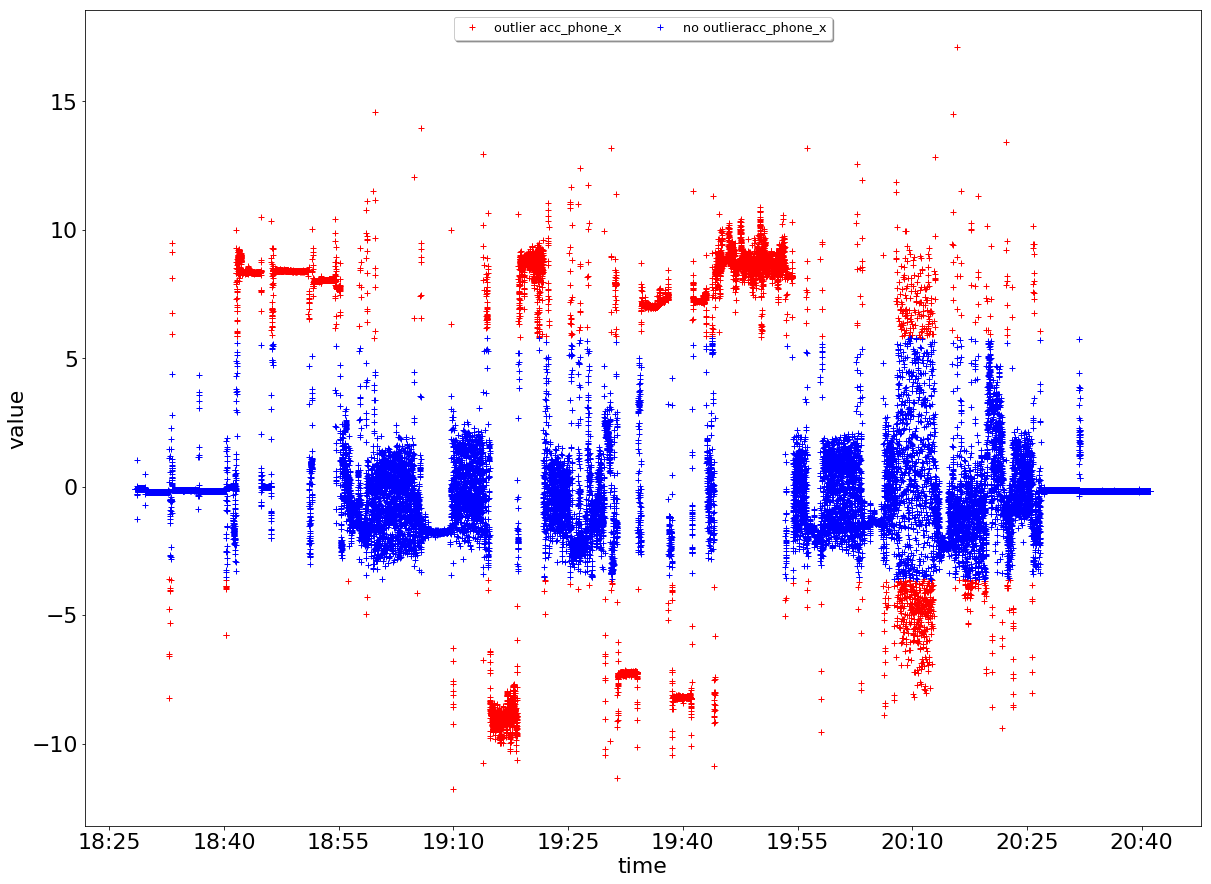

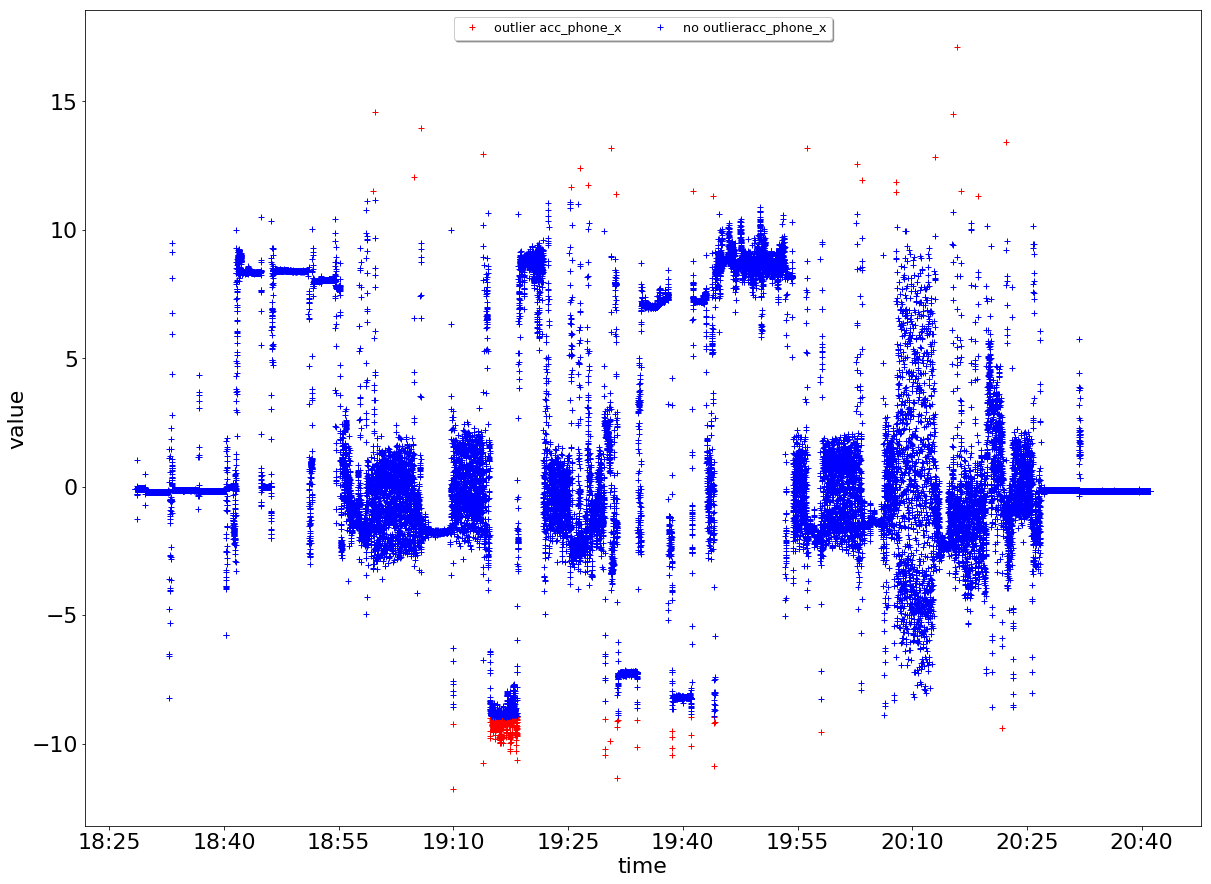

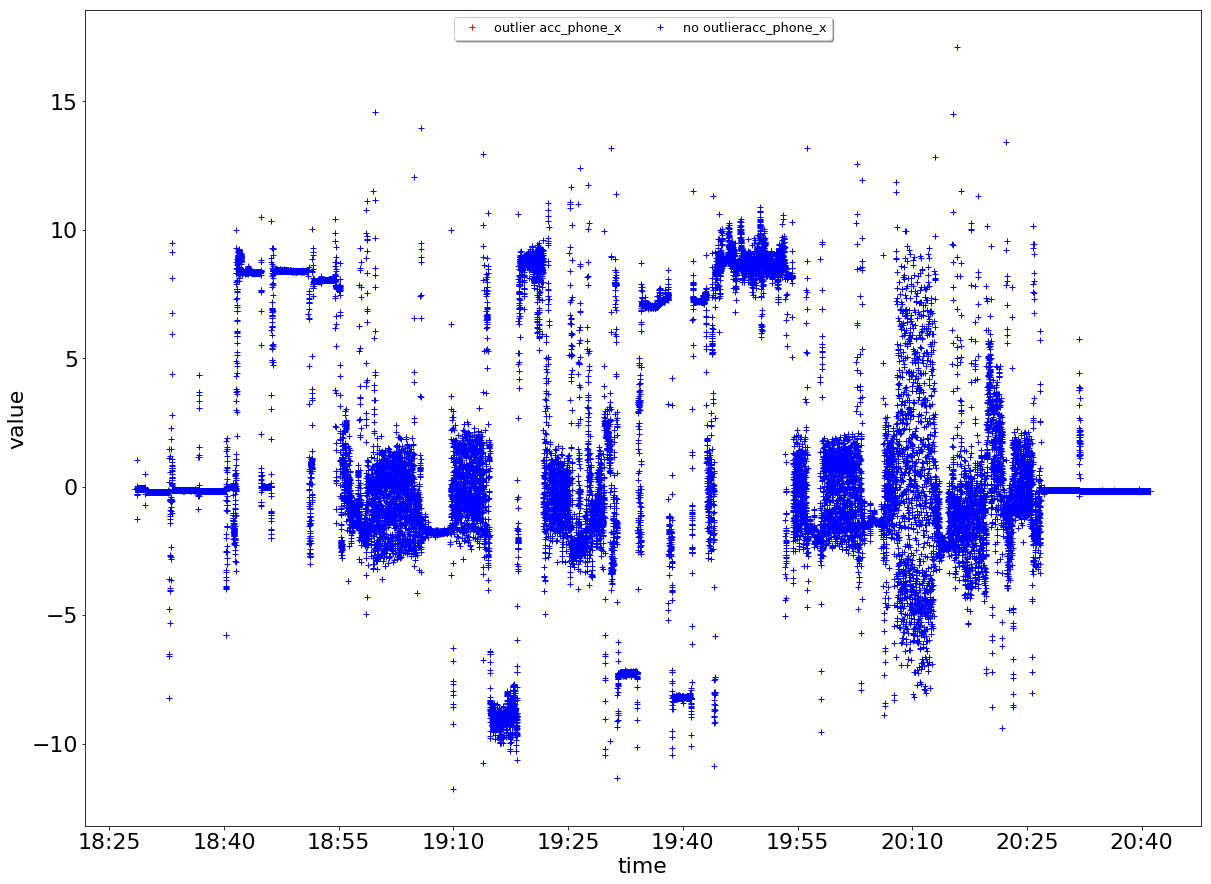

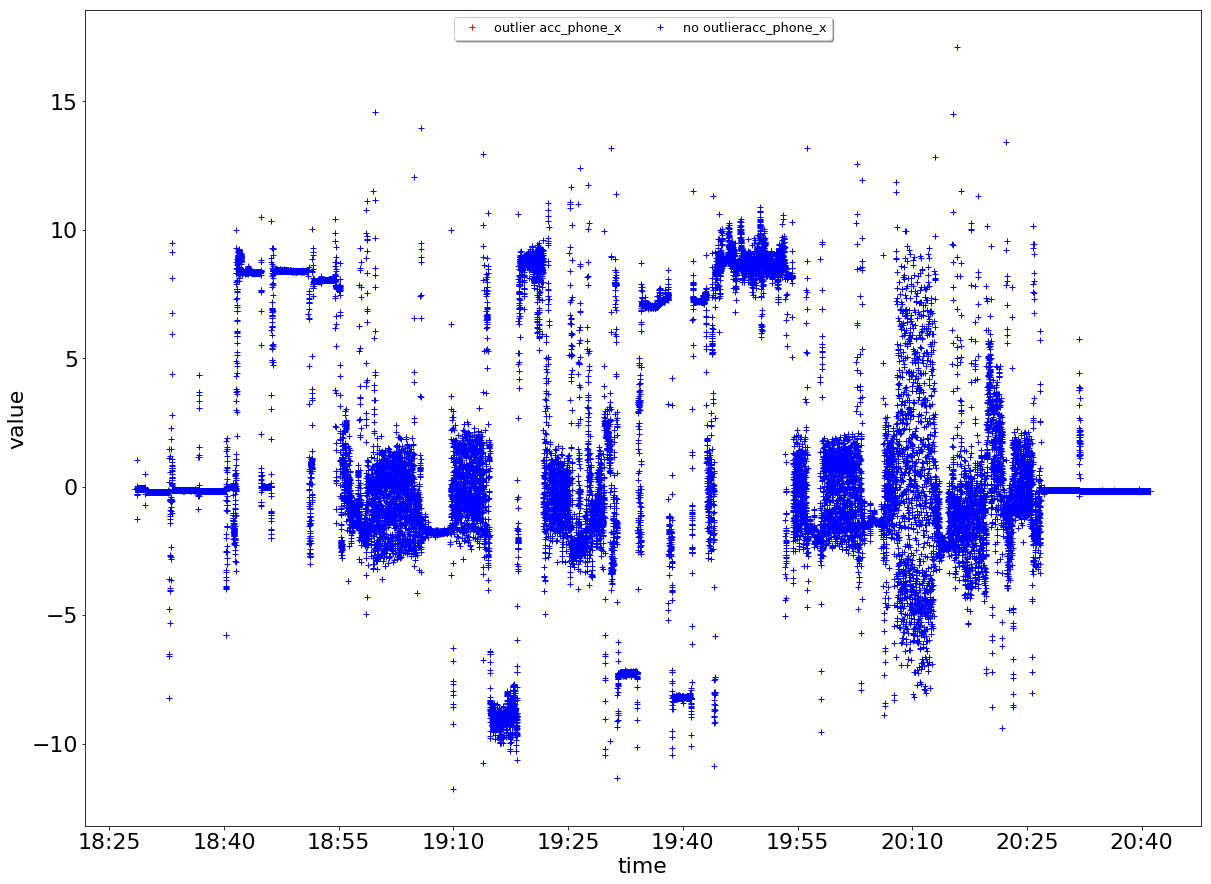

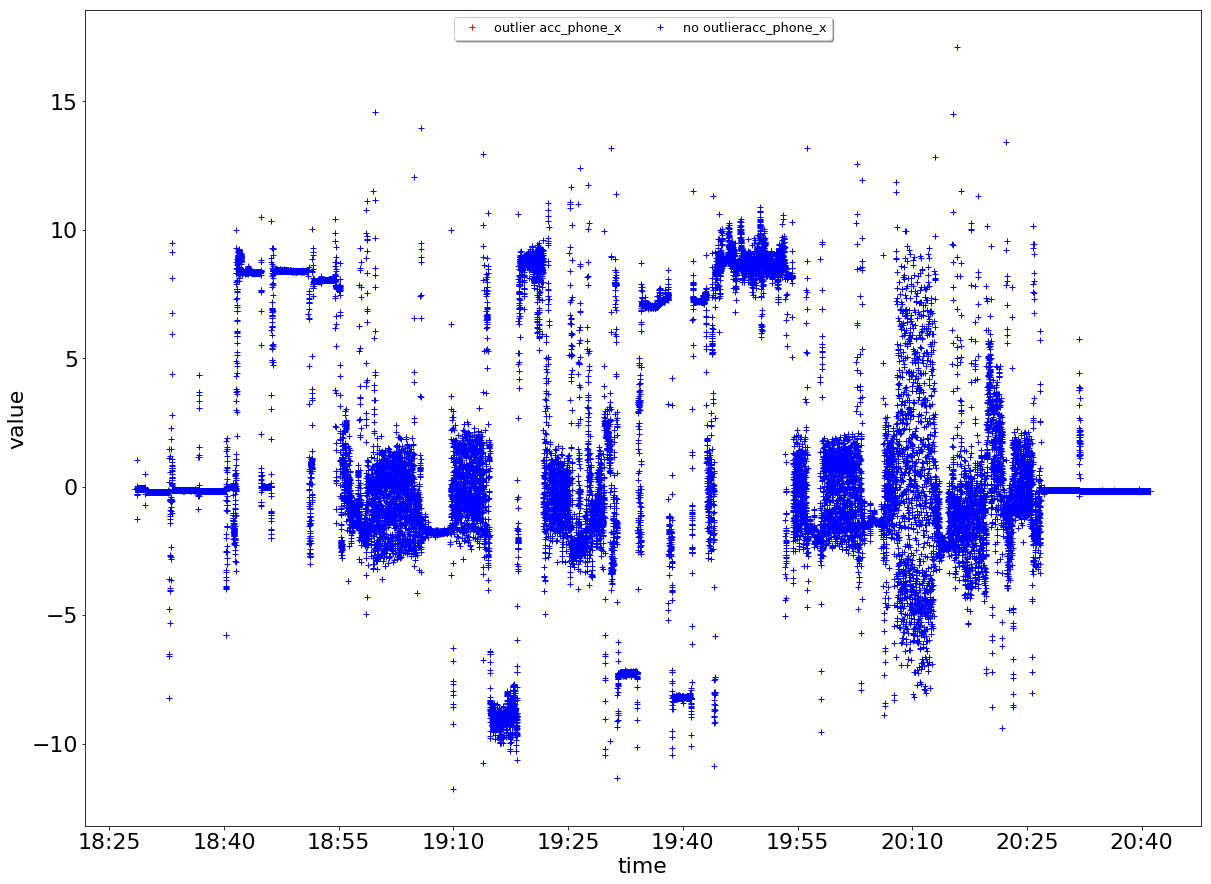

In [9]:
for c in [0.0001,0.001,0.1,1,2]:
    dataset_outliers_chauvenet = OutlierDistr.chauvenet(copy.deepcopy(data), col, c)
    DataViz.plot_binary_outliers(dataset_outliers_chauvenet, col, col + '_outlier')

# higher c corresponds to higher chance that outliers are truly outliers

### Distribution-based: Mixture models

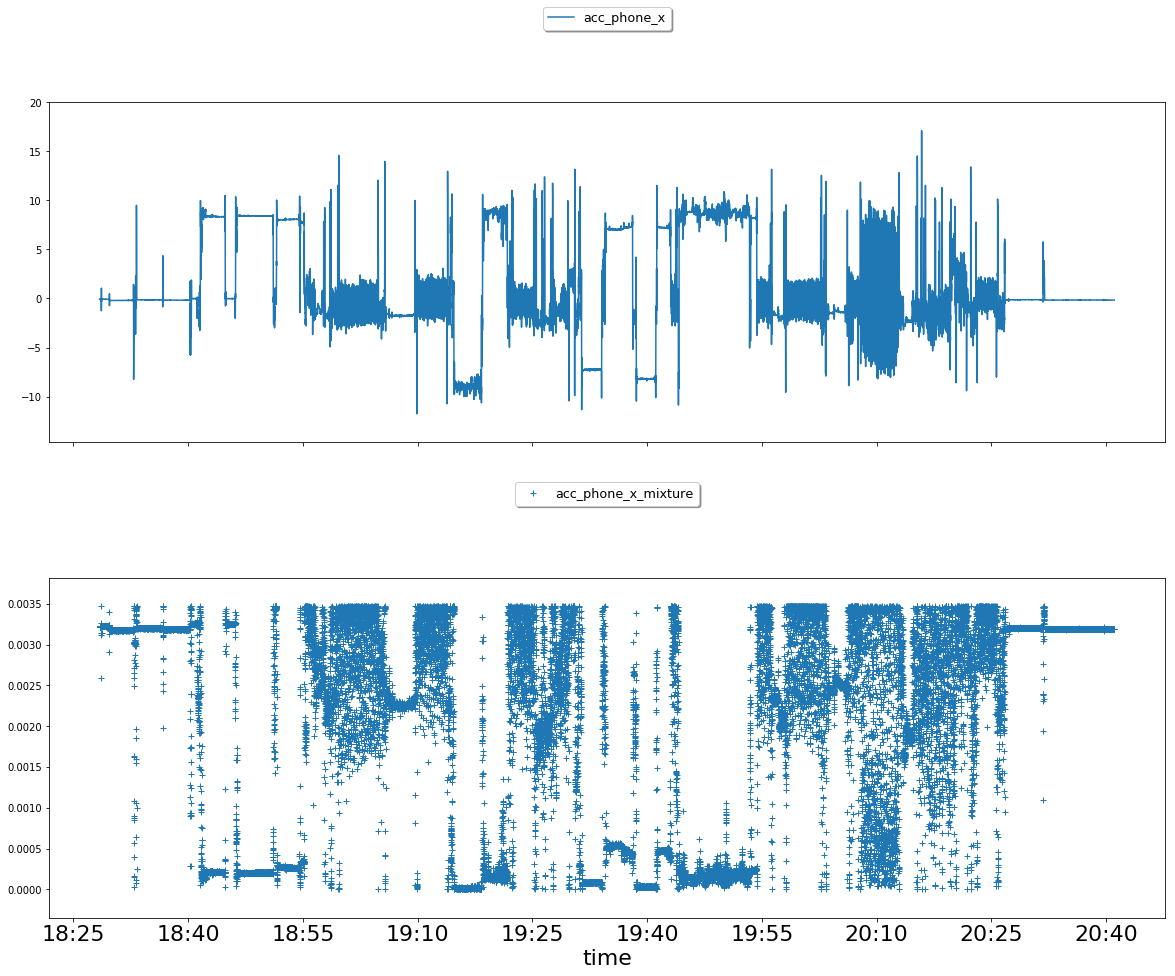

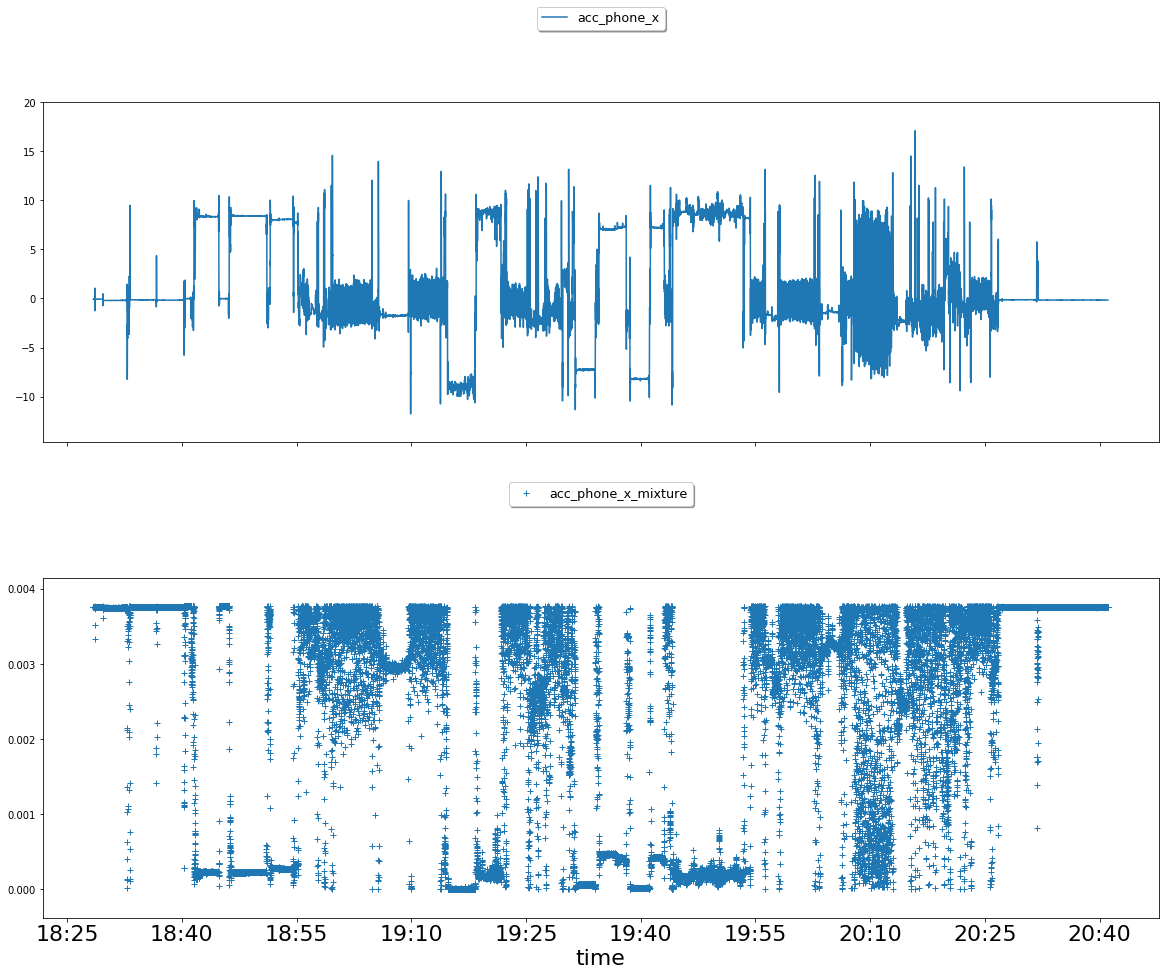

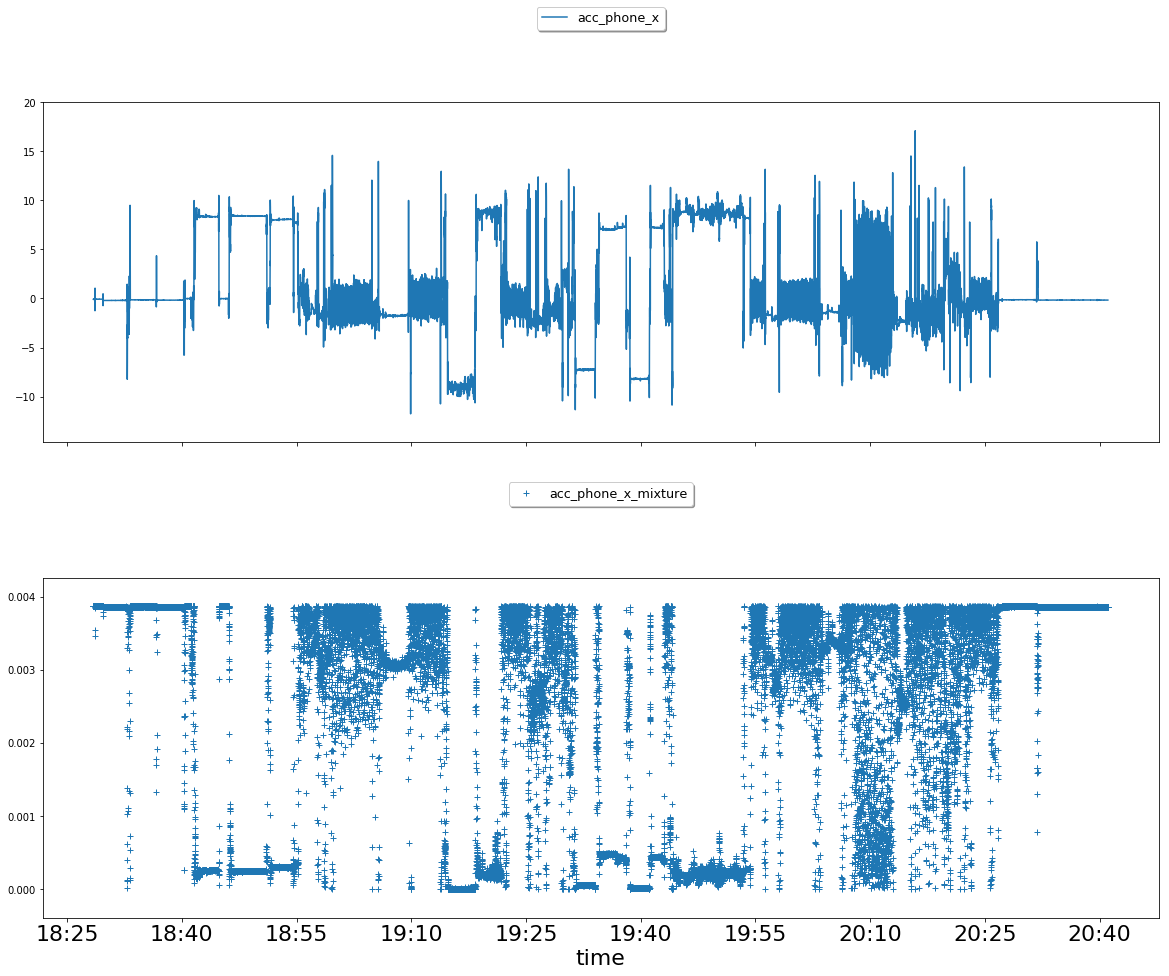

In [11]:
# ignore DeprecationWarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

for k in [1,10,100]:
    dataset_outliers_mixture = OutlierDistr.mixture_model(copy.deepcopy(data), col, k)
    DataViz.plot_dataset(dataset_outliers_mixture, [col, col + '_mixture'], ['exact','exact'], ['line', 'points'])

# higher values of k result in higher probabilities of observing a datapoint (as expected, since this allows for
# a better fit to the dataset). The resulting dataset however hardly differs. Choosing low value is in this case fine,
# this saves some computation.

### Distance-based: Simple distance-based approach

In [ ]:
from Chapter3.OutlierDetection import DistanceBasedOutlierDetection

OutlierDist = DistanceBasedOutlierDetection()

In [ ]:
dataset_outliers_sdb = OutlierDist.simple_distance_based(copy.deepcopy(data), [col], 'euclidean', 0.10, 0.99)

In [ ]:
DataViz.plot_binary_outliers(dataset_outliers_sdb, col, 'simple_dist_outlier')

### Distance-based: Local outlier factor

In [74]:
dataset_outliers_lof = OutlierDist.local_outlier_factor(copy.deepcopy(data), [col], 'euclidean', 5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172


KeyboardInterrupt: 

# Chapter 4: Feature Engineering Based on Sensory Data